### IMPORT DATA DAN INSPECTION

In [2]:
import pandas as pd
df = pd.read_csv('https://storage.googleapis.com/dqlab-dataset/data_retail.csv', sep=';')


In [3]:
#df.head()

In [4]:
#df.info()

### DATA CLEANSING

In [5]:
df['First_Transaction'] = pd.to_datetime(df['First_Transaction']/1000, unit='s', origin='1970-01-01')

df['Last_Transaction'] = pd.to_datetime(df['Last_Transaction']/1000, unit='s', origin='1970-01-01')


In [6]:
#df

### CHURN CUSTOMER

In [7]:
# Pengecekan transaksaksi terakhir dalam dataset

#print(max(df['Last_Transaction']))

In [8]:
# Menentukan customer 'is churn' 

df.loc[df['Last_Transaction'] >= '2018-08-01', 'is churn'] = False
df.loc[df['Last_Transaction'] < '2018-08-01', 'is churn'] = True

#df

### DELETING COLUMN

In [9]:
df = df.drop(columns=['no','Row_Num'])

In [10]:
#df

### CUSTOMER ACQUISITION BY YEAR

In [11]:
df['Year_First_Transaction'] = df['First_Transaction'].dt.year

df['Year_Last_Transaction'] = df['Last_Transaction'].dt.year

#df

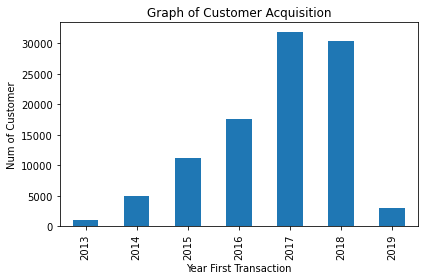

In [12]:
import matplotlib.pyplot as plt

df_year = df.groupby(['Year_First_Transaction'])['Customer_ID'].count()
df_year.plot(x='Year_First_Transaction', y='Customer_ID', kind='bar', title='Graph of Customer Acquisition')
plt.xlabel('Year First Transaction')
plt.ylabel('Num of Customer')
plt.tight_layout()
plt.show()

### TRANSACTION BY YEAR

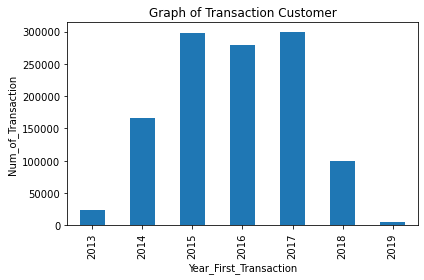

In [13]:
plt.clf()
df_year = df.groupby(['Year_First_Transaction'])['Count_Transaction'].sum()
df_year.plot(x='Year_First_Transaction', y='Count_Transaction', kind='bar', title='Graph of Transaction Customer')
plt.xlabel('Year_First_Transaction')
plt.ylabel('Num_of_Transaction')
plt.tight_layout()
plt.show()

### AVERAGE TRANSACTION AMOUNT BY YEAR

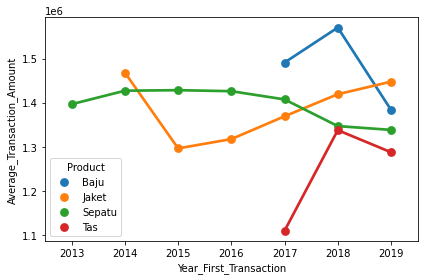

In [14]:
import seaborn as sns

plt.clf()
sns.pointplot(data = df.groupby(['Product', 'Year_First_Transaction']).mean().reset_index(), 
              x='Year_First_Transaction', 
              y='Average_Transaction_Amount', 
              hue='Product')
plt.tight_layout()
plt.show()

### PROPORSI CHURNED CUSTOMER UNTUK SETIAP PRODUCT

<Figure size 432x288 with 0 Axes>

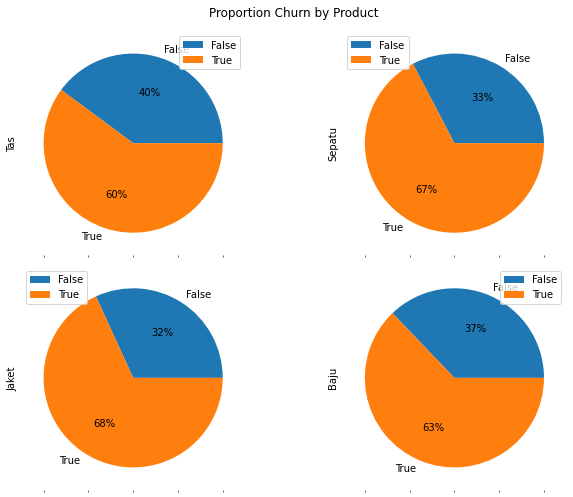

In [15]:
plt.clf()
# Melakukan pivot data dengan pivot_table
df_piv = df.pivot_table(index='is churn', 
                        columns='Product',
                        values='Customer_ID', 
                        aggfunc='count', 
                        fill_value=0)

# Mendapatkan Proportion Churn by Product
plot_product = df_piv.count().sort_values(ascending=False).head(5).index

# Plot pie chartnya
df_piv = df_piv.reindex(columns=plot_product)
df_piv.plot.pie(subplots=True,
                figsize=(10, 7),
                layout=(-1, 2),
                autopct='%1.0f%%',
                title='Proportion Churn by Product')
plt.tight_layout()
plt.show()

### DISTRIBUSI KATEGORI COUNT TRANSACTION

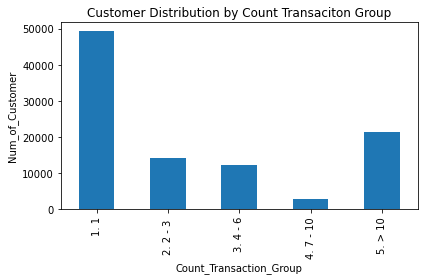

In [16]:
plt.clf()
# Kategorisasi jumlah transaksi
def func(row):
    if row['Count_Transaction'] == 1:
        val = '1. 1'
    elif (row['Count_Transaction'] > 1 and row['Count_Transaction'] <= 3):
        val ='2. 2 - 3 '
    elif (row['Count_Transaction'] > 3 and row['Count_Transaction'] <= 6):
        val ='3. 4 - 6'
    elif (row['Count_Transaction'] > 6 and row['Count_Transaction'] <= 10):
        val ='4. 7 - 10'
    else:
        val ='5. > 10'
    return val
# Tambahkan kolom baru
df['Count_Transaction_Group'] = df.apply(func, axis=1)

df_year = df.groupby(['Count_Transaction_Group'])['Customer_ID'].count()
df_year.plot(x='COunt_Transaction_Group', y='Customer_ID', kind='bar', title='Customer Distribution by Count Transaciton Group')
plt.xlabel('Count_Transaction_Group')
plt.ylabel('Num_of_Customer')
plt.tight_layout()
plt.show()

### DISTRIBUSI KATEGORISASI AVERAGE TRANSACTION AMOUNT

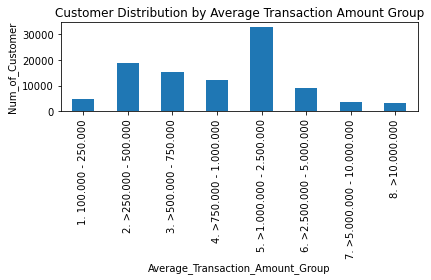

In [17]:
plt.clf()
# Kategorisasi rata-rata besar transaksi
def f(row):
    if (row['Average_Transaction_Amount'] >= 100000 and row['Average_Transaction_Amount'] <= 200000):
        val ='1. 100.000 - 250.000'
    elif (row['Average_Transaction_Amount'] > 250000 and row['Average_Transaction_Amount'] <= 500000):
        val ='2. >250.000 - 500.000'
    elif (row['Average_Transaction_Amount'] > 500000 and row['Average_Transaction_Amount'] <= 750000):
        val='3. >500.000 - 750.000'
    elif (row['Average_Transaction_Amount'] > 750000 and row['Average_Transaction_Amount'] <= 1000000):
        val='4. >750.000 - 1.000.000'
    elif (row['Average_Transaction_Amount'] > 1000000 and row['Average_Transaction_Amount'] <= 2500000):
        val='5. >1.000.000 - 2.500.000'
    elif (row['Average_Transaction_Amount'] > 2500000 and row['Average_Transaction_Amount'] <= 5000000):
        val='6. >2.500.000 - 5.000.000'
    elif (row['Average_Transaction_Amount'] > 5000000 and row['Average_Transaction_Amount'] <= 10000000):
        val='7. >5.000.000 - 10.000.000'
    else:
        val='8. >10.000.000'
    return val
# Tambahkan kolom baru
df['Average_Transaction_Amount_Group'] = df.apply(f, axis=1)

df_year = df.groupby(['Average_Transaction_Amount_Group'])['Customer_ID'].count()
df_year.plot(x='Average_Transaction_Amount_Group', y='Customer_ID', kind='bar', title='Customer Distribution by Average Transaction Amount Group')
plt.xlabel('Average_Transaction_Amount_Group')
plt.ylabel('Num_of_Customer')
plt.tight_layout()
plt.show()

### Feature Columns dan Target

In [18]:
# Feature column: Year_Diff
df['Year_Diff'] = df['Year_Last_Transaction'] - df['Year_First_Transaction']

# Nama-nama feature columns
feature_columns = ['Average_Transaction_Amount', 'Count_Transaction', 'Year_Diff']

# Features variable
X = df['Year_Diff'] 

# Target variable
y = df['is churn']

#df.head()

### Split X dan y ke dalam bagian training dan testing

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### Train, predict dan evaluate

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


# Inisiasi model logreg
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train)

# Predict model
y_pred = logreg.predict(X_test)

# Evaluasi model menggunakan confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cnf_matrix)


ValueError: Expected 2D array, got 1D array instead:
array=[2. 0. 2. ... 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### VISUALISASI CONFUSION MATRIX

NameError: name 'cnf_matrix' is not defined

<Figure size 432x288 with 0 Axes>

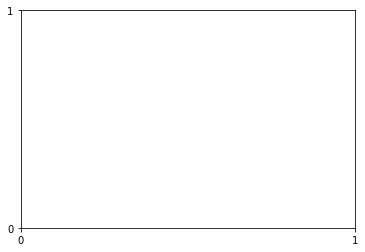

In [29]:
# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
# name  of classes
class_names = [0, 1] 
fig, ax = plt.subplots()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGnBu', fmt='g')
ax.xaxis.set_label_position('top')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

### ACCURACY, PRECISION, RECALL

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

#Menghitung Accuracy, Precision, dan Recall
print('Accuracy :', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='micro'))
print('Recall   :', recall_score(y_test, y_pred, average='micro'))